<a href="https://colab.research.google.com/github/andrewCoder2024/tensorflow-training/blob/main/Tranformer_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import transformers

In [ ]:
import torch

In [ ]:
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

In [ ]:
path = "/content/gdrive/My Drive/AskRedditjson/"

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from datasets import Dataset

In [ ]:


raw_train_ds = Dataset.from_json(path+"train.jsonlines")
raw_val_ds = Dataset.from_json(path+"val.jsonlines")
raw_test_ds = Dataset.from_json(path+"test.jsonlines")

# This line prints the description of train_ds
raw_train_ds, raw_val_ds, raw_test_ds

Using custom data configuration default-c386bd1509aa2890
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-c386bd1509aa2890/0.0.0)
Using custom data configuration default-00356432b6586688
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-00356432b6586688/0.0.0)
Using custom data configuration default-f3e9b8a7c86ecfd0
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-f3e9b8a7c86ecfd0/0.0.0)


(Dataset({
     features: ['title', 'upvote_ratio', 'num_comments', 'score'],
     num_rows: 162761
 }), Dataset({
     features: ['title', 'upvote_ratio', 'num_comments', 'score'],
     num_rows: 40691
 }), Dataset({
     features: ['title', 'upvote_ratio', 'num_comments', 'score'],
     num_rows: 50863
 }))

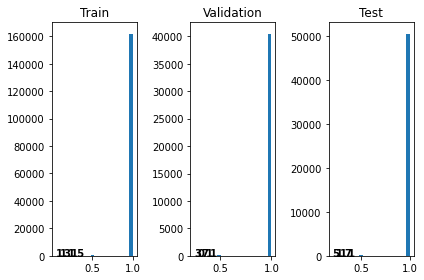

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(raw_train_ds["upvote_ratio"], bins=20)
val_distributions = axs[1].hist(raw_val_ds["upvote_ratio"], bins=20)
test_distributions = axs[2].hist(raw_test_ds["upvote_ratio"], bins=20)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

# Let's name the classes 0, 1, 2, 3, 4 like their indices
id2label = {k:k for k in range(5)}
label2id = {k:k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id,ignore_mismatched_sizes=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/camembert-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4qc2gn3t


Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
creating metadata file for /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
loading configuration file https://huggingface.co/camembert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
Model config CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
creating metadata file for /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
https://huggingface.co/camembert-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_1v7unwq


Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/84c442cc6020fc04ce266072af54b040f770850f629dd86c5951dbc23ac4c0dd.8fd2f10f70e05e6bf043e8a6947f6cdf9bb5dc937df6f9210a5c0ba8ee48e959
creating metadata file for /root/.cache/huggingface/transformers/84c442cc6020fc04ce266072af54b040f770850f629dd86c5951dbc23ac4c0dd.8fd2f10f70e05e6bf043e8a6947f6cdf9bb5dc937df6f9210a5c0ba8ee48e959
loading file https://huggingface.co/camembert-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
loading file https://huggingface.co/camembert-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/84c442cc6020fc04ce266072af54b040f770850f629dd86c5951dbc23ac4c0dd.8fd2f10f70e05e6bf043e8a6947f6cdf9bb5dc937df6f9210a5c0ba8ee48e959
loading file https:/

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
creating metadata file for /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
loading weights file https://huggingface.co/camembert-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'ro

In [ ]:
id2label

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [ ]:

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["title"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["title","upvote_ratio", "num_comments", "score"])

  0%|          | 0/162761 [00:00<?, ?ex/s]

  0%|          | 0/40691 [00:00<?, ?ex/s]

  0%|          | 0/50863 [00:00<?, ?ex/s]

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

Using eos_token, but it is not set yet.


In [ ]:
ds["train"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=path+"model1",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:

from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 162761
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 203460


In [ ]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

In [ ]:

import torch
import pandas as pd

input_texts = ["C'est très bien", 
               "Je vais y aller.", 
               "J'en ai marre.", 
               "Vous ne foutez rien !!!", 
               "Je vous remercie infiniment pour cet excellent service !!!"
              ]

# Encode the text
encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")

# Call the model to predict under the format of logits of 5 classes
logits = model(**encoded).logits

# Get the class
torch.argmax(logits, axis=1)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

In [ ]:

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])

In [ ]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

In [ ]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../models/camembert-fine-tuned-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [ ]:

import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

In [ ]:

trainer.eval_dataset=ds["test"]
trainer.evaluate()

In [ ]:
import math
import pandas as pd

nb_batches = math.ceil(len(raw_test_ds)/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["score"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()

pd.set_option('display.max_rows', 500)
df = pd.DataFrame([raw_test_ds["text"], raw_test_ds["score"], y_preds], ["Text", "Score", "Prediction"]).T
df["Rounded Prediction"] = df["Prediction"].apply(round)
incorrect_cases = df[df["Score"] != df["Rounded Prediction"]]
incorrect_cases

In [ ]:

from sklearn.metrics import confusion_matrix
confusion_matrix(df["Score"].tolist(), df["Rounded Prediction"].tolist())